In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [38]:
snp500 = yf.download("^GSPC", start="2000-01-01", end="2024-01-01")
stocks = ["AAPL", "MSFT", "GOOGL","AMZN","NVDA","TSLA","META"] 
stock_data = yf.download(stocks, start="2000-01-01", end="2024-01-01")["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed


In [39]:
data = pd.concat([snp500['Adj Close'], stock_data], axis=1).dropna()
data.columns = ['S&P 500'] + stocks 
correlations = data.corr()['S&P 500'].sort_values(ascending=False)
print("Correlations with S&P 500:")
print(correlations)

Correlations with S&P 500:
S&P 500    1.000000
GOOGL      0.984529
NVDA       0.975840
AAPL       0.959357
MSFT       0.930660
META       0.899687
AMZN       0.894335
TSLA       0.869279
Name: S&P 500, dtype: float64


In [40]:
stock_data = stock_data.drop(columns=["AMZN", "TSLA", "META","NVDA"])
stock_data

,AAPL,GOOGL,MSFT
Date,,,
2000-01-03,0.843076,NaN,35.864071
2000-01-04,0.771997,NaN,34.652576
2000-01-05,0.783294,NaN,35.017956
2000-01-06,0.715509,NaN,33.844913
2000-01-07,0.749402,NaN,34.287216
...,...,...,...
2023-12-22,192.656174,141.140518,371.799713
2023-12-26,192.108871,141.170441,371.879150
2023-12-27,192.208359,140.023270,371.293518


In [41]:
snp_returns = snp500['Adj Close'].pct_change().dropna()
stock_returns = stock_data.pct_change().dropna()
data = pd.concat([snp_returns, stock_returns], axis=1).dropna()
train = data['2022-12-15':'2023-01-01']
test = data['2023-01-01':]
train,test

(            Adj Close      AAPL     GOOGL      MSFT
 Date                                               
 2022-12-15  -0.024922 -0.046854 -0.044283 -0.031918
 2022-12-16  -0.011138 -0.014579 -0.006604 -0.017349
 2022-12-19  -0.009008 -0.015910 -0.020164 -0.017328
 2022-12-20   0.001037 -0.000529  0.006558  0.005615
 2022-12-21   0.014868  0.023810  0.006291  0.010877
 2022-12-22  -0.014452 -0.023773 -0.020317 -0.025529
 2022-12-23   0.005868 -0.002798  0.016750  0.002267
 2022-12-27  -0.004050 -0.013878 -0.020621 -0.007414
 2022-12-28  -0.012021 -0.030685 -0.015677 -0.010255
 2022-12-29   0.017461  0.028325  0.028249  0.027630
 2022-12-30  -0.002541  0.002469 -0.002487 -0.004938,
             Adj Close      AAPL     GOOGL      MSFT
 Date                                               
 2023-01-03  -0.004001 -0.037405  0.010087 -0.001001
 2023-01-04   0.007539  0.010314 -0.011670 -0.043743
 2023-01-05  -0.011646 -0.010605 -0.021344 -0.029638
 2023-01-06   0.022841  0.036794  0.013225  0

In [42]:
snp2023 = snp500['Adj Close'].dropna()['2023-01-01':]
snp2023

Date
2023-01-03    3824.139893
2023-01-04    3852.969971
2023-01-05    3808.100098
2023-01-06    3895.080078
2023-01-09    3892.090088
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: Adj Close, Length: 250, dtype: float64

In [43]:
class ParticleFilter:
    def __init__(self, num_particles, state_dim, transition_model, observation_model):
        self.num_particles = num_particles
        self.state_dim = state_dim
        self.particles = np.random.randn(num_particles, state_dim)
        self.weights = np.ones(num_particles) / num_particles
        self.transition_model = transition_model
        self.observation_model = observation_model

    def predict(self):
        self.particles = self.transition_model(self.particles)

    def update(self, observations):
        weights = np.array([self.observation_model(p, observations) for p in self.particles])
        if np.sum(weights) == 0:  
            self.weights = np.ones(self.num_particles) / self.num_particles
        else:
            self.weights = weights / np.sum(weights)

    def resample(self):
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

def transition_model(particles):
    return particles + np.random.normal(0, 0.01, particles.shape)

def observation_model(state, observations):
    predicted_return = state[0]
    actual_return = observations[0]
    likelihood = norm.pdf(actual_return, loc=predicted_return, scale=0.01)
    return likelihood



In [44]:
pf = ParticleFilter(num_particles=3000, state_dim=1, transition_model=transition_model, observation_model=observation_model)

for idx, row in train.iterrows():
    pf.predict()
    pf.update(row.values)
    pf.resample()


<Axes: title={'center': 'S&P 500 Prediction with Particle Filter'}, xlabel='Date'>

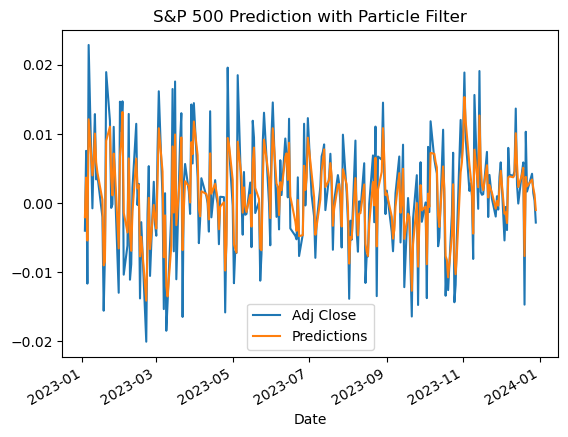

In [45]:
predictions = []
for idx, row in test.iterrows():
    pf.predict()
    pf.update(row.values)
    pf.resample()
    predicted_value = pf.estimate()[0]
    predictions.append(predicted_value)

test1 = test.copy()  
test1.loc[:, 'Predictions'] = predictions
test1[['Adj Close', 'Predictions']].plot(title="S&P 500 Prediction with Particle Filter")

In [46]:
test2=test1.copy()
initial_price_date = snp500['Adj Close'].loc['2023-01-01':].index[0]
initial_price = snp500['Adj Close'].loc[initial_price_date]
print(f"Initial price on {initial_price_date}: {initial_price}")

test2['Predicted Prices'] = initial_price * (1 + test1['Predictions']).cumprod()
test2['Actual Prices']=snp2023

test2

Initial price on 2023-01-03 00:00:00: 3824.139892578125


,Adj Close,AAPL,GOOGL,MSFT,Predictions,Predicted Prices,Actual Prices
Date,,,,,,,
2023-01-03,-0.004001,-0.037405,0.010087,-0.001001,-0.002051,3816.298123,3824.139893
2023-01-04,0.007539,0.010314,-0.011670,-0.043743,0.003676,3830.325331,3852.969971
2023-01-05,-0.011646,-0.010605,-0.021344,-0.029638,-0.005423,3809.554280,3808.100098
2023-01-06,0.022841,0.036794,0.013225,0.011785,0.012101,3855.654265,3895.080078
2023-01-09,-0.000768,0.004089,0.007786,0.009736,0.003989,3871.035589,3892.090088
...,...,...,...,...,...,...,...
2023-12-22,0.001660,-0.005548,0.007620,0.002784,0.002402,4758.680659,4754.629883
2023-12-26,0.004232,-0.002841,0.000212,0.000214,0.003400,4774.859458,4774.750000
2023-12-27,0.001430,0.000518,-0.008126,-0.001575,0.002169,4785.218406,4781.580078


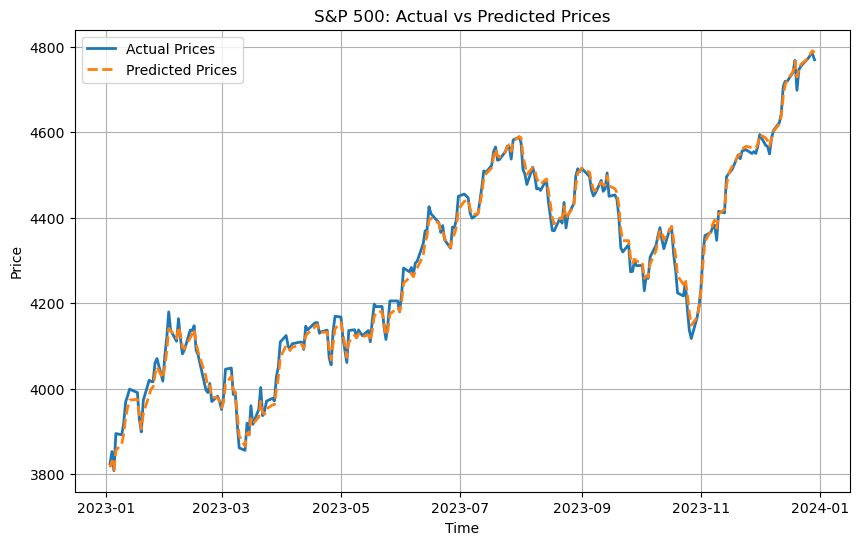

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(test2['Actual Prices'], label='Actual Prices', linewidth=2)
plt.plot(test2['Predicted Prices'], label='Predicted Prices', linestyle='--', linewidth=2)
plt.title("S&P 500: Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()

In [48]:
#MSE
mse=((test2['Actual Prices'] - test2['Predicted Prices']) ** 2).mean()
mse

301.2637569116713